<a href="https://colab.research.google.com/github/agorastats/mitosisDEEP/blob/master/colabs/v2_drive_retrain_icpr12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# todo
# train with autoencoders: https://www.youtube.com/watch?v=hTpq9lzAb8M&t=710s
# learning rate: https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
# batch size, steps per epoch: https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps
# try another loss function: https://github.com/nauyan/Segmentation/blob/master/Code/utils/lossfunctions.py
# dice coefficient evaluation criteria: https://www.kaggle.com/yerramvarun/understanding-dice-coefficient

In [ ]:
# import packages
import os
import tensorflow as tf
import numpy as np 
import random
import cv2
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [ ]:
# utils
def read_image(filename):
    assert os.path.exists(filename), 'Problems reading filename %s' % filename
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def read_mask(filename):
    assert os.path.exists(filename), 'Problems reading filename %s' % filename
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, black_white_image) = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return black_white_image

def read_patches_of_folder(folder_path, convert=False):
    all_patches_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    print('total patches: ', len(all_patches_files))
    all_patches_list = []
    for i, patch in enumerate(all_patches_files):
        if i%500==0:
          print('processed number of patches: %i' % i)
        if convert:
          all_patches_list.append(read_mask(os.path.join(folder_path, patch)))
        else:
          all_patches_list.append(read_image(os.path.join(folder_path, patch)))
    return all_patches_list



In [ ]:
# unzip images to read it
# '/content/drive/MyDrive/mitosis_data/images_aug.zip'
# !unzip '/content/drive/MyDrive/mitosis_data/images_aug_255.zip' -d "/content/images_aug_255"
# !unzip '/content/drive/MyDrive/mitosis_data/masks_aug_255.zip' -d "/content/masks_aug_255"

!unzip '/content/drive/MyDrive/mitosis_data/images_aug_2021_12_15.zip' -d "/content/images_aug"
!unzip '/content/drive/MyDrive/mitosis_data/masks_aug_2021_12_15.zip' -d "/content/masks_aug"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/images_aug/images_aug_2021_12_15/A03_08_7_3.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/A01_03_5_2.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/H00_04_2_1.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/A02_09_3_7_3.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/H01_00_1_0.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/H01_00_1_2.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/H00_06_4_4_0.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/H00_06_4_4_3.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/H02_04_7_0_3.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/A01_03_1_1.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/A01_03_1_3.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/A01_07_1_3.jpg  
  inflating: /content/images_aug/images_aug_2021_12_15/A02_05_4_5_1

In [ ]:
# images_list = read_patches_of_folder('/content/images_aug/images_aug')

# images_list = read_patches_of_folder('/content/images_aug_255/images_aug')
# masks_list = read_patches_of_folder('/content/masks_aug_255/masks_aug', convert=True)

# images_list = read_patches_of_folder('/content/images_aug_stain/images_aug2')
# masks_list = read_patches_of_folder('/content/masks_aug_stain/masks_aug2', convert=True)


images_list = read_patches_of_folder('/content/images_aug/images_aug_2021_12_15')
images = np.array(images_list)
del images_list

masks_list = read_patches_of_folder('/content/masks_aug/masks_aug_2021_12_15', convert=True)
masks = np.array(masks_list)
del masks_list
masks = np.expand_dims(masks, -1)

print('total images patches: ', np.array(images).shape)
print('total masks patches: ', np.array(masks).shape)

total patches:  4274
processed number of patches: 0
processed number of patches: 500
processed number of patches: 1000
processed number of patches: 1500
processed number of patches: 2000
processed number of patches: 2500
processed number of patches: 3000
processed number of patches: 3500
processed number of patches: 4000
total patches:  4274
processed number of patches: 0
processed number of patches: 500
processed number of patches: 1000
processed number of patches: 1500
processed number of patches: 2000
processed number of patches: 2500
processed number of patches: 3000
processed number of patches: 3500
processed number of patches: 4000
total images patches:  (4274, 256, 256, 3)
total masks patches:  (4274, 256, 256, 1)


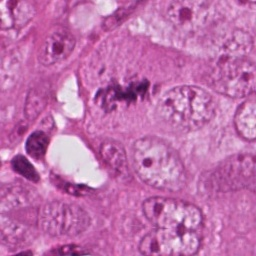

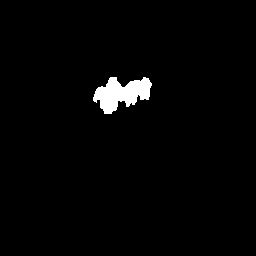

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(images[20])
cv2_imshow(masks[20])

In [ ]:
# utils keras
from keras import backend as K

# ref: https://github.com/nauyan/Segmentation/blob/master/Code/utils/lossfunctions.py
# ref: https://github.com/nauyan/Segmentation/blob/master/Code/utils/metricfunctions.py

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

  return 1 - numerator / denominator

def jaccard_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
# load trained model
from keras.models import load_model
model = load_model("drive/MyDrive/mitosis_data/UNET-Best.h5", compile=False)
# model.save_weights("drive/MyDrive/mitosis_data/pretrained_weights.h5")

# build model
# adapted Adam optimizer with low learning rate
opt_adam = keras.optimizers.Adam(learning_rate=0.00001)
# model.compile(optimizer=opt_adam, loss='binary_crossentropy', metrics=[dice_coef, 'accuracy'])
# model.compile(optimizer=opt_adam, loss=dice_loss, metrics=[dice_coef, 'accuracy'])
model.compile(optimizer=opt_adam, loss=jaccard_loss, metrics=[dice_coef, 'accuracy'])

# normal Adam optimizer
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, 'accuracy'])

# Change to dice_loss
# model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef, 'accuracy'])


# model.load_weights("drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_jaccard_loss.h5")
model.load_weights("drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_jaccard_loss_retrain.h5")


# model.load_weights("drive/MyDrive/mitosis_data/pretrained_weights.h5")
# model.load_weights('drive/MyDrive/mitosis_data/best_retrain_weights.h5')
# model.load_weights("drive/MyDrive/mitosis_data/best_retrain_weights_with_dice_loss.h5")
# model.load_weights("drive/MyDrive/mitosis_data/best_retrain_weights_with_dice_loss_not_norm_stain.h5")
# model.load_weights("drive/MyDrive/mitosis_data/retrain_weights_with_dice_loss_data_augmented255.h5")
# model.load_weights("drive/MyDrive/mitosis_data/2retrain_weights_with_dice_loss_data_augmented255.h5")
# iter realitzada 2021-12-15
# model.load_weights("drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_cv2Color.h5")
# model.load_weights("drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_cv2Color_retrain_v2_sense_cv2Color.h5")
# model.load_weights("drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_cv2Color_retrain_3.h5")
# model.load_weights("drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_retrain_3_1_with_jaccard_loss.h5")


In [ ]:
seed_val=10
from keras.preprocessing.image import ImageDataGenerator

# img_data_gen_args = dict(rescale=1. / 255,
#                      rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      fill_mode='reflect')

# mask_data_gen_args = dict(rescale=1. / 255,
#                      rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      fill_mode='reflect',
#                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.5) # 0.33

# img_data_gen_args = dict(rescale=1./255)
# mask_data_gen_args = dict()

image_data_generator = ImageDataGenerator(rescale=1.0/255)
image_generator = image_data_generator.flow(X_train, seed=seed_val)
valid_img_generator = image_data_generator.flow(X_test, seed=seed_val)

# **mask_data_gen_args
mask_data_generator = ImageDataGenerator(rescale=1.0/255)
mask_generator = mask_data_generator.flow(y_train, seed=seed_val)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed_val)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [ ]:
# train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

weight_path="drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_jaccard_loss_retrain.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

steps_per_epoch = 4000. / 32  # 32: batch size
# steps_per_epoch = 20
epoch_number = 50
batch_size = 32

history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=epoch_number,
                    callbacks=[callback, checkpoint])

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.0055 - dice_coef: 0.5962 - accuracy: 0.9944
Epoch 00001: val_loss improved from inf to 0.00442, saving model to drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_jaccard_loss_retrain.h5
125/125 [==============================] - 131s 1s/step - loss: 0.0055 - dice_coef: 0.5962 - accuracy: 0.9944 - val_loss: 0.0044 - val_dice_coef: 0.7137 - val_accuracy: 0.9955
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.0046 - dice_coef: 0.6721 - accuracy: 0.9954
Epoch 00002: val_loss improved from 0.00442 to 0.00420, saving model to drive/MyDrive/mitosis_data/retrain_augmented_data_2021_12_15_jaccard_loss_retrain.h5
125/125 [==============================] - 127s 1s/step - loss: 0.0046 - dice_coef: 0.6721 - accuracy: 0.9954 - val_loss: 0.0042 - val_dice_coef: 0.7143 - val_accuracy: 0.9958
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.0041 - dice_coef: 0.7157 - accurac

In [ ]:
#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: ignored

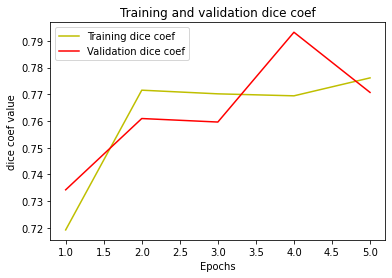

In [ ]:
#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
loss = history.history['dice_coef']
val_loss = history.history['val_dice_coef']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice coef')
plt.plot(epochs, val_loss, 'r', label='Validation dice coef')
plt.title('Training and validation dice coef')
plt.xlabel('Epochs')
plt.ylabel('dice coef value')
plt.legend()
plt.show()

In [ ]:
# ref: https://www.youtube.com/watch?v=HrGn4uFrMOM
# predict on some images
from google.colab.patches import cv2_imshow
!pip install patchify
from patchify import patchify, unpatchify
PATCH_SIZE  = 256
# test_path = 'drive/MyDrive/mitosis_data/A00_01.bmp'
test_path = 'drive/MyDrive/mitosis_data/A01_09.bmp'  # validation
# test_path = 'drive/MyDrive/mitosis_data/30.jpg'   
# test_path = 'drive/MyDrive/mitosis_data/23.jpg'   
# test_path = 'drive/MyDrive/mitosis_data/25.jpg'   
test_image = read_image(test_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
# test_image = np.array(test_image) 
# cv2_imshow(test_image)

test image size:  (2084, 2084, 3)
test image resized size:  (2048, 2048, 3)


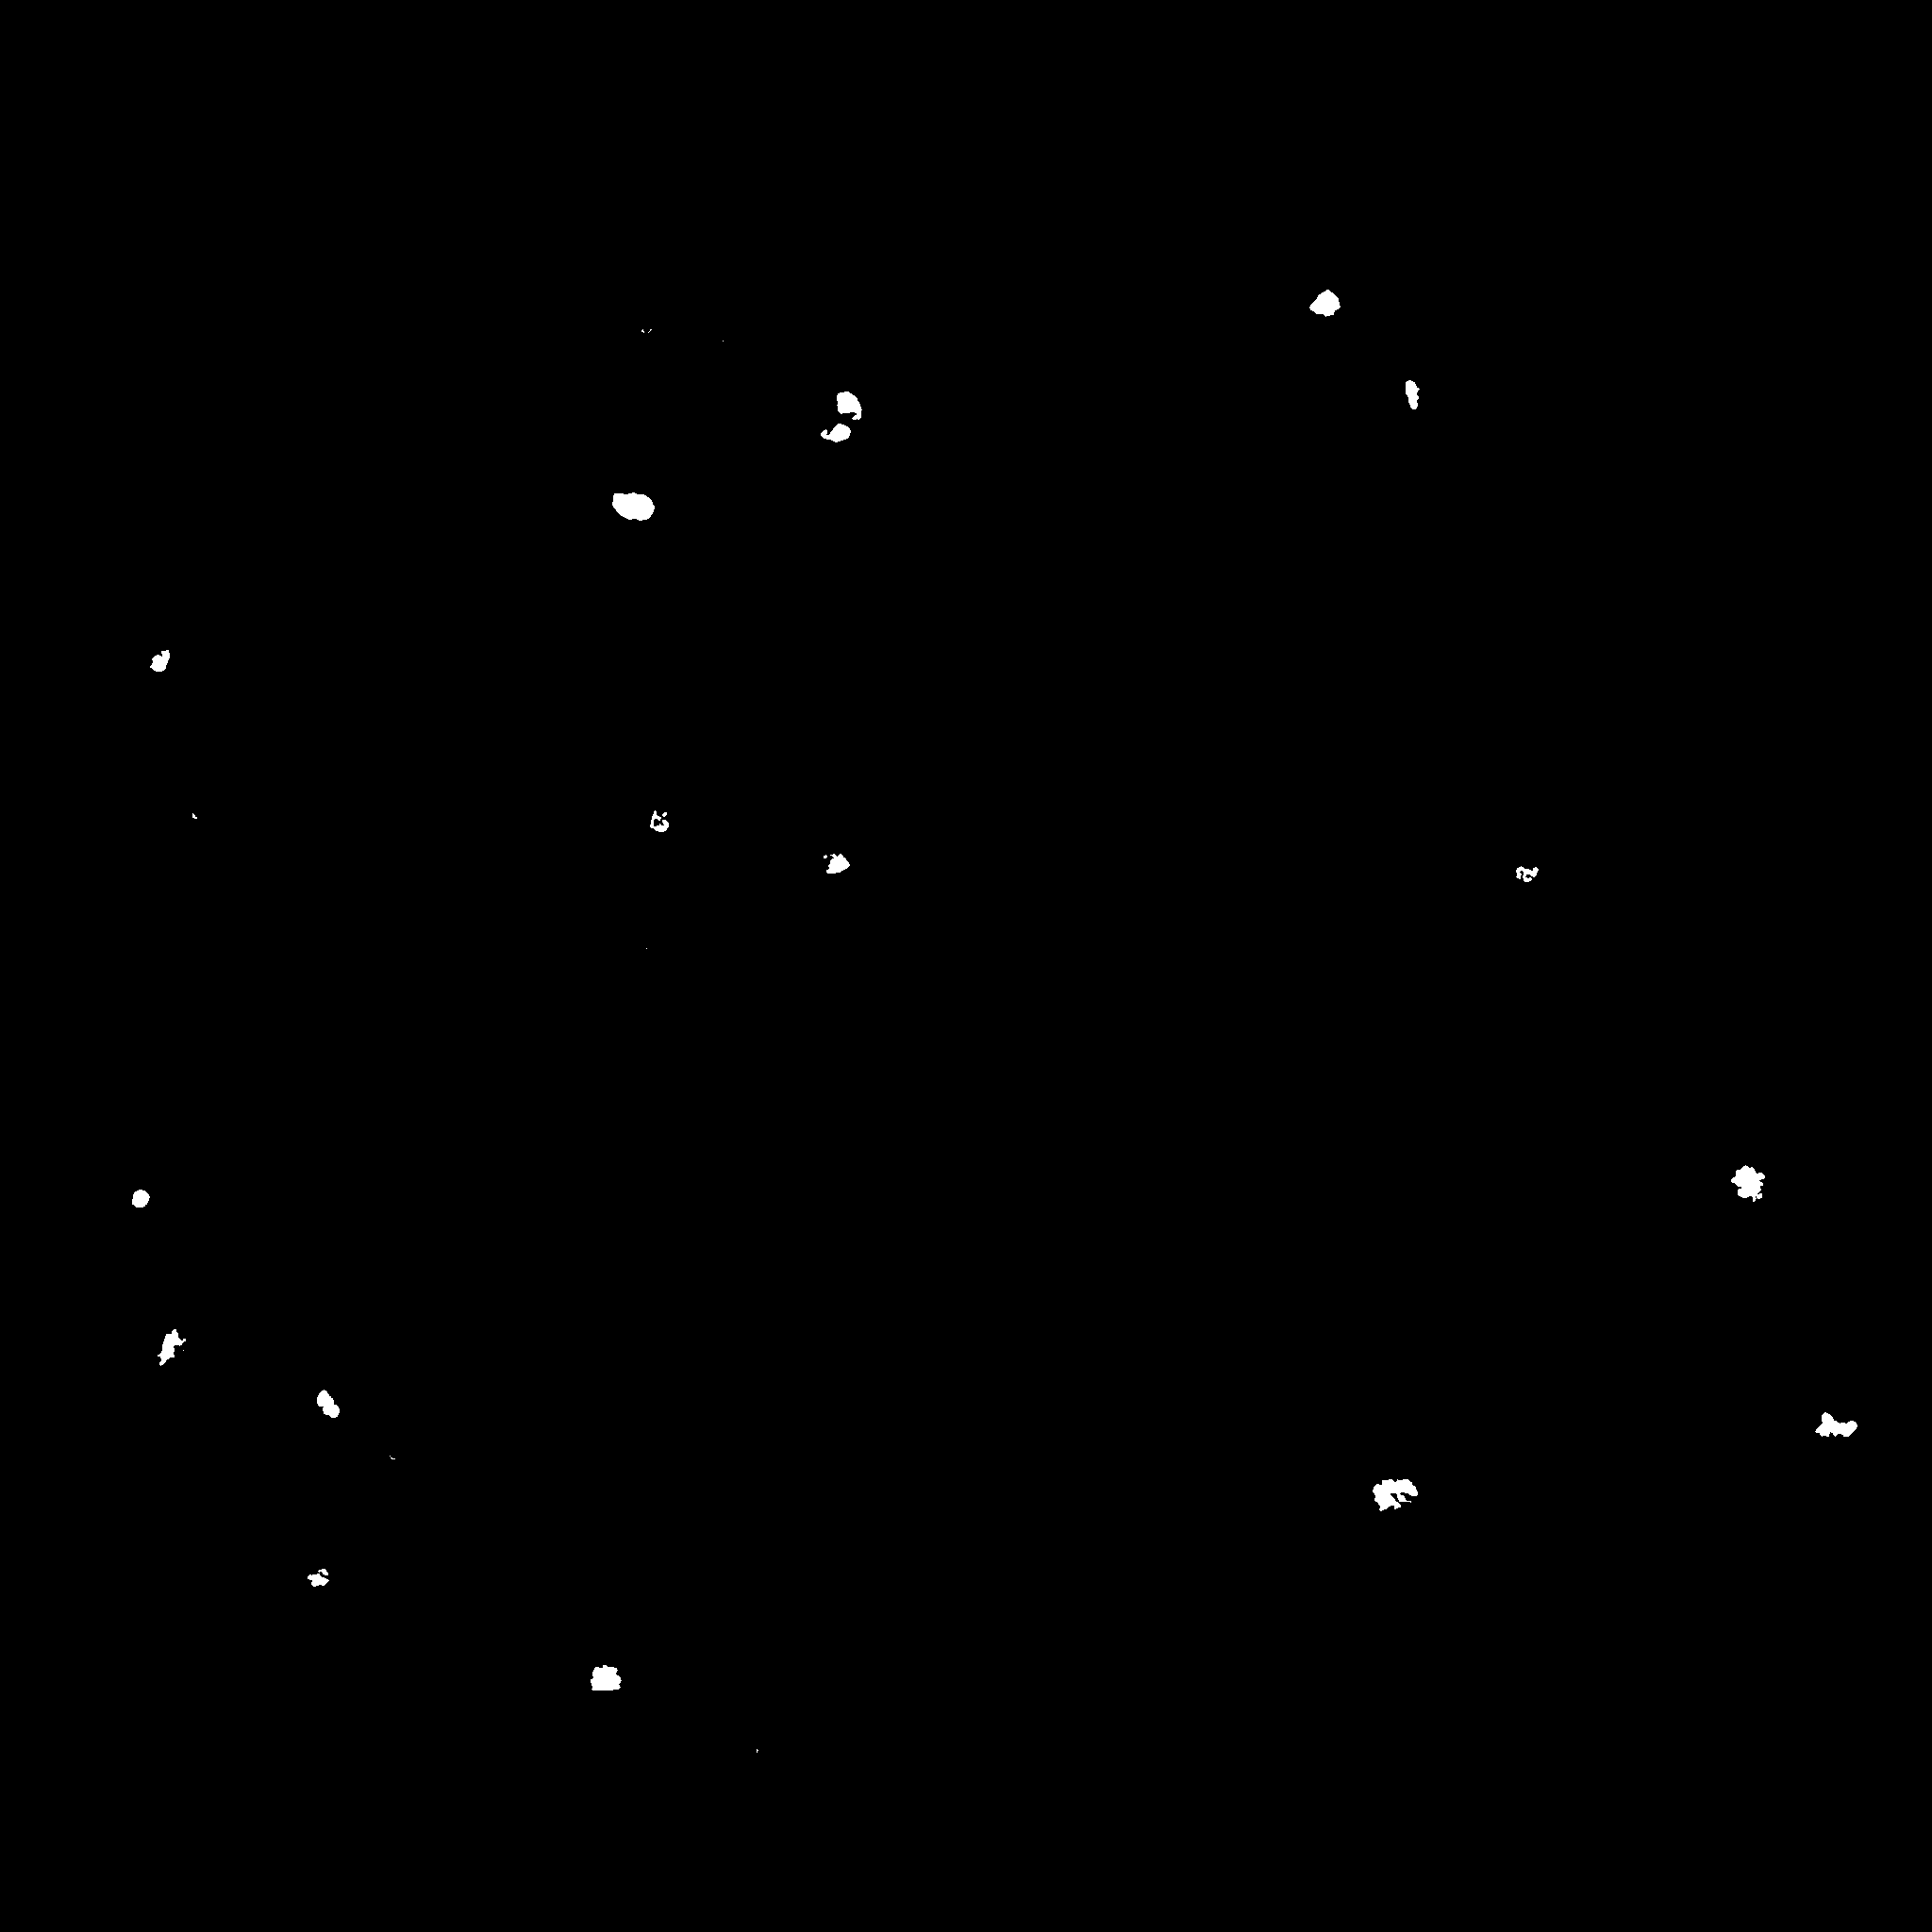

In [ ]:
size_x = (test_image.shape[1]//PATCH_SIZE)*PATCH_SIZE   # nearest size divisible by our patch size
size_y = (test_image.shape[0]//PATCH_SIZE)*PATCH_SIZE   # nearest size divisible by our patch size
print('test image size: ', test_image.shape)
test_image = cv2.resize(test_image, (size_x, size_y))
print('test image resized size: ', test_image.shape)

patches = patchify(test_image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)  # step same as patch for not overlap patches
patches = patches[:, :, 0, :, :, :]
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i,j,:,:, :] / 255.   # normalize
        single_patch = np.expand_dims(single_patch, axis=0) # (256,256,3) to (1,256,256,3)
        # predict thresh > k
        single_patch_prediction = (model.predict(single_patch) > 0.5).astype(np.uint8)
        predicted_patches.append(single_patch_prediction[0, :, :])


predicted_patches_reshaped = np.reshape(predicted_patches, [patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]]) 
reconstructed_image = unpatchify(predicted_patches_reshaped, (test_image.shape[0], test_image.shape[1]))
cv2_imshow(reconstructed_image * 255.) # multiply to visualize graph




In [ ]:
# random patches
j  = np.random.choice(range(len(X_test)), 1)
# j = np.array([871])
print('random patch:' , j)
cv2_imshow(X_test[j][0])
cv2_imshow(y_test[j][0])
pred = (model.predict(X_test[j] / 255.) > 0.5).astype(np.uint8) 
print(' sum(pred): ', pred.sum())
cv2_imshow(pred[0] * 255.)

NameError: ignored

In [ ]:
# ref: https://www.kaggle.com/yerramvarun/understanding-dice-coefficient

# As seen above, we need to calculate the intersection pixels in the masks.
# Since our masks consist of just 0s and 1s, simple multiplication will leave us with intersection pixels

def get_dice_value(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

